In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

In [3]:
pd.options.display.max_columns = None

Ref: <https://keras.io/examples/timeseries/timeseries_weather_forecasting/>

## Load Training Data

In [4]:
data_dir = Path.cwd().parent / 'DATA'

In [5]:
train_data = data_dir / 'train_data.parquet'

In [6]:
train_df = pd.read_parquet(train_data)
print(f"training dataframe -> rows: {train_df.shape[0]}, cols: {train_df.shape[1]}")

training dataframe -> rows: 375734, cols: 246


In [7]:
TARGET = 'contest-tmp2m-14d__tmp2m'

## Load Grouped Columns

In [8]:
cols_file = 'artifacts/columns.json'
print("Column Group (n) \n---------------")
with open(cols_file, 'r') as js_in:
    groups_cols = json.load(js_in)
    for group, col_list in groups_cols.items():
        print(f"{group}: {len(col_list)}")

Column Group (n) 
---------------
info: 3
geography: 4
precip: 4
nmme0: 30
wind-h: 44
nmme: 40
pressure: 2
wind-v: 42
wind-u: 42
temp_forecast: 10
mjo: 2
mei: 3
sst: 10
icec: 10


In [9]:
keep_groups = ['info', 'geography', 'precip', 'pressure', 'temp-forecast', 'mjo', 'mei']

In [10]:
keep_cols = []
for group, col_list in groups_cols.items():
    if group in keep_groups:
        keep_cols.extend(col_list)
    else:
        for col_nm in col_list:
            if col_nm.find('2010-10') > -1 or col_nm.find('contest') > -1:
                keep_cols.append(col_nm)
keep_cols.remove('index')
print(f"Keep columns: {len(keep_cols)}")

Keep columns: 35


In [11]:
train_df['location'] = list(zip(train_df.lat, train_df.lon))

In [12]:
COORD = 0.5

In [13]:
sngl_lctn_df = train_df.loc[train_df['location'] == (COORD, COORD), keep_cols]
sngl_lctn_df.index = pd.to_datetime(sngl_lctn_df['startdate'])
sngl_lctn_df[['year', 'week', 'day']] = sngl_lctn_df.index.isocalendar()
sngl_lctn_df['month'] = sngl_lctn_df.index.month
sngl_lctn_df['day_of_year'] = sngl_lctn_df.index.day_of_year
n_rows, n_cols = sngl_lctn_df.shape
print(f"single location sample -> rows: {n_rows}, cols: {n_cols}")

single location sample -> rows: 731, cols: 40


In [14]:
LEVELS = 50

In [15]:
const_cols = []
cat_cols = []
print("colunms: levels\n-------------")
for col in sngl_lctn_df.columns:
    n_levels = len(sngl_lctn_df[col].unique())
    if n_levels == 1:
        const_cols.append(col)
    elif n_levels <= LEVELS:
        cat_cols.append(col)
    print(f"{col}:\t{n_levels}")

colunms: levels
-------------
startdate:	731
contest-tmp2m-14d__tmp2m:	731
lat:	1
lon:	1
climateregions__climateregion:	1
elevation__elevation:	1
contest-pevpr-sfc-gauss-14d__pevpr:	723
contest-rhum-sig995-14d__rhum:	692
contest-prwtr-eatm-14d__prwtr:	541
contest-precip-14d__precip:	562
contest-wind-h10-14d__wind-hgt-10:	724
contest-wind-h100-14d__wind-hgt-100:	726
contest-wind-h850-14d__wind-hgt-850:	704
contest-wind-h500-14d__wind-hgt-500:	722
wind-hgt-850-2010-10:	730
wind-hgt-500-2010-10:	731
wind-hgt-10-2010-10:	731
wind-hgt-100-2010-10:	730
contest-slp-14d__slp:	729
contest-pres-sfc-gauss-14d__pres:	728
contest-wind-vwnd-925-14d__wind-vwnd-925:	263
contest-wind-vwnd-250-14d__wind-vwnd-250:	625
wind-vwnd-250-2010-10:	722
wind-vwnd-925-2010-10:	710
contest-wind-uwnd-250-14d__wind-uwnd-250:	637
contest-wind-uwnd-925-14d__wind-uwnd-925:	240
wind-uwnd-250-2010-10:	727
wind-uwnd-925-2010-10:	717
mjo1d__phase:	8
mjo1d__amplitude:	251
mei__mei:	25
mei__meirank:	14
mei__nip:	2
sst-2010-10

In [16]:
dont_describe = const_cols + cat_cols
print(f"constants: {const_cols}")
print(f"categorical: {cat_cols}")

constants: ['lat', 'lon', 'climateregions__climateregion', 'elevation__elevation']
categorical: ['mjo1d__phase', 'mei__mei', 'mei__meirank', 'mei__nip', 'year', 'day', 'month']


In [17]:
sngl_lctn_df.drop(columns=dont_describe).describe()

,contest-tmp2m-14d__tmp2m,contest-pevpr-sfc-gauss-14d__pevpr,contest-rhum-sig995-14d__rhum,contest-prwtr-eatm-14d__prwtr,contest-precip-14d__precip,contest-wind-h10-14d__wind-hgt-10,contest-wind-h100-14d__wind-hgt-100,contest-wind-h850-14d__wind-hgt-850,contest-wind-h500-14d__wind-hgt-500,wind-hgt-850-2010-10,wind-hgt-500-2010-10,wind-hgt-10-2010-10,wind-hgt-100-2010-10,contest-slp-14d__slp,contest-pres-sfc-gauss-14d__pres,contest-wind-vwnd-925-14d__wind-vwnd-925,contest-wind-vwnd-250-14d__wind-vwnd-250,wind-vwnd-250-2010-10,wind-vwnd-925-2010-10,contest-wind-uwnd-250-14d__wind-uwnd-250,contest-wind-uwnd-925-14d__wind-uwnd-925,wind-uwnd-250-2010-10,wind-uwnd-925-2010-10,mjo1d__amplitude,sst-2010-10,icec-2010-10,week,day_of_year
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.0,731.000000
mean,9.865088,236.731395,60.507989,9.328249,17.392367,31053.787989,16429.943776,1509.040096,5756.991628,272.871518,-1172.818495,1094.103297,413.487223,101732.856758,79133.962681,0.578605,-0.048865,0.362668,6.560684,17.663611,0.615732,-7.673912,0.741724,1.301122,21.688933,0.127031,26.70725,183.083447
std,8.908607,181.406831,17.459226,4.015639,14.793967,320.704675,180.873864,20.011486,111.160937,619.919910,962.075978,1932.365867,1611.081304,368.042474,266.437979,0.711133,7.675858,97.705479,35.144673,6.521467,0.635844,91.210181,58.716937,0.726181,5.524986,0.273624,15.196311,105.390181
min,-7.262686,9.000000,25.100000,4.040000,0.070000,30410.480000,16156.740000,1440.860000,5525.030000,-1147.360000,-4049.950000,-4620.950000,-3539.530000,101183.200000,78272.900000,-1.430000,-19.870000,-343.260000,-80.900000,3.430000,-0.950000,-269.120000,-177.720000,0.040000,6.200000,-0.730000,1.0,1.000000
25%,2.526399,74.685000,43.910000,5.615000,4.100000,30795.535000,16273.560000,1495.890000,5670.950000,-117.530000,-1799.550000,-304.140000,-646.205000,101473.545000,78923.450000,0.090000,-5.685000,-56.945000,-17.415000,13.320000,0.150000,-69.515000,-36.300000,0.780000,18.860000,0.005000,14.0,92.000000
50%,9.105576,191.960000,66.200000,8.640000,13.040000,30982.340000,16368.070000,1511.920000,5733.590000,223.050000,-1166.100000,1276.140000,227.680000,101593.930000,79213.610000,0.600000,0.890000,11.220000,6.430000,17.160000,0.570000,-8.790000,4.160000,1.190000,22.060000,0.130000,27.0,183.000000
75%,18.720258,402.060000,74.805000,12.120000,28.190000,31365.390000,16621.495000,1522.170000,5868.155000,689.520000,-463.225000,2626.820000,1654.320000,101979.740000,79340.845000,1.080000,5.035000,76.155000,28.300000,22.250000,1.050000,60.510000,34.160000,1.665000,24.765000,0.280000,40.0,274.000000
max,24.518594,674.940000,86.650000,18.790000,72.250000,31573.240000,16754.610000,1572.670000,5951.260000,2086.250000,976.990000,4713.070000,4817.600000,102965.440000,79636.920000,2.380000,17.280000,196.580000,92.790000,34.520000,2.620000,248.930000,161.990000,4.620000,37.280000,0.760000,53.0,365.000000


In [18]:
FIG_SIZE = (21, 12)

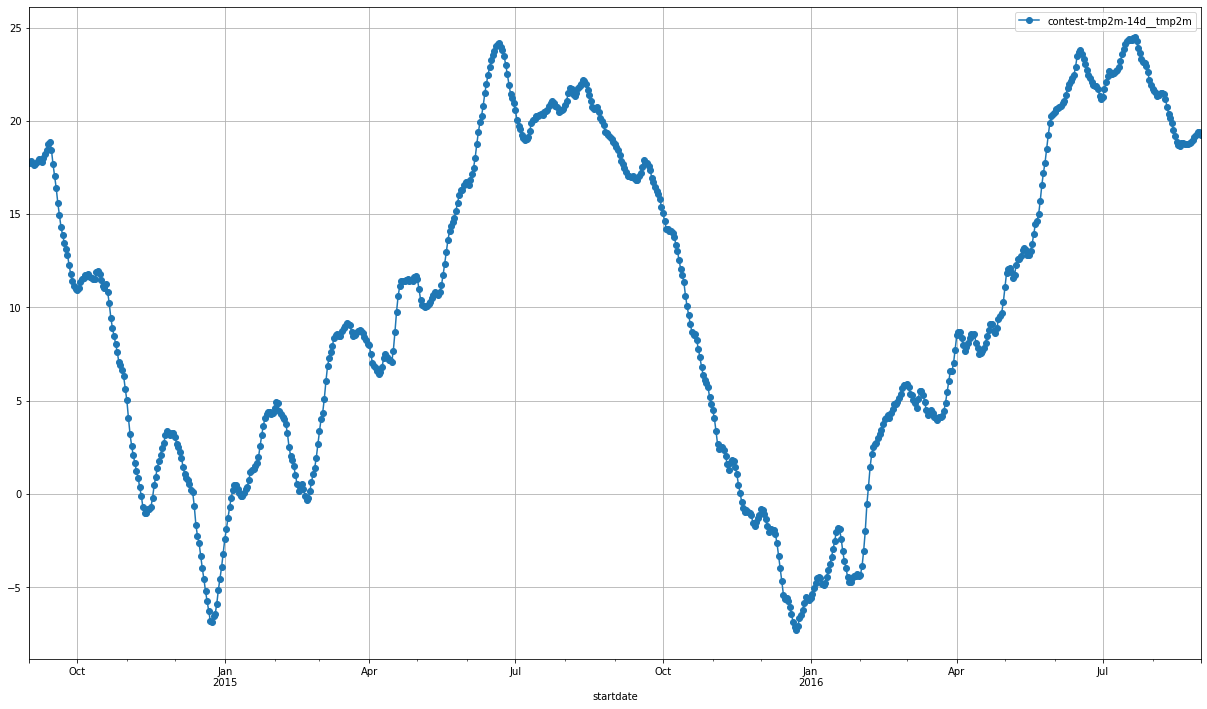

In [19]:
viz_trgt_df = sngl_lctn_df[['startdate', TARGET]]
viz_trgt_df.set_index('startdate')
viz_trgt_df.plot.line(marker='o', figsize=FIG_SIZE)
plt.grid()
plt.show()

## Ref: Timeseries forecasting for weather prediction
<https://keras.io/examples/timeseries/timeseries_weather_forecasting/>

In [20]:
drop_cols = const_cols + ['startdate']

In [21]:
def show_heatmap(data):
    plt.figure(figsize=FIG_SIZE)
    plt.matshow(data.corr(numeric_only=True), fignum=1)
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

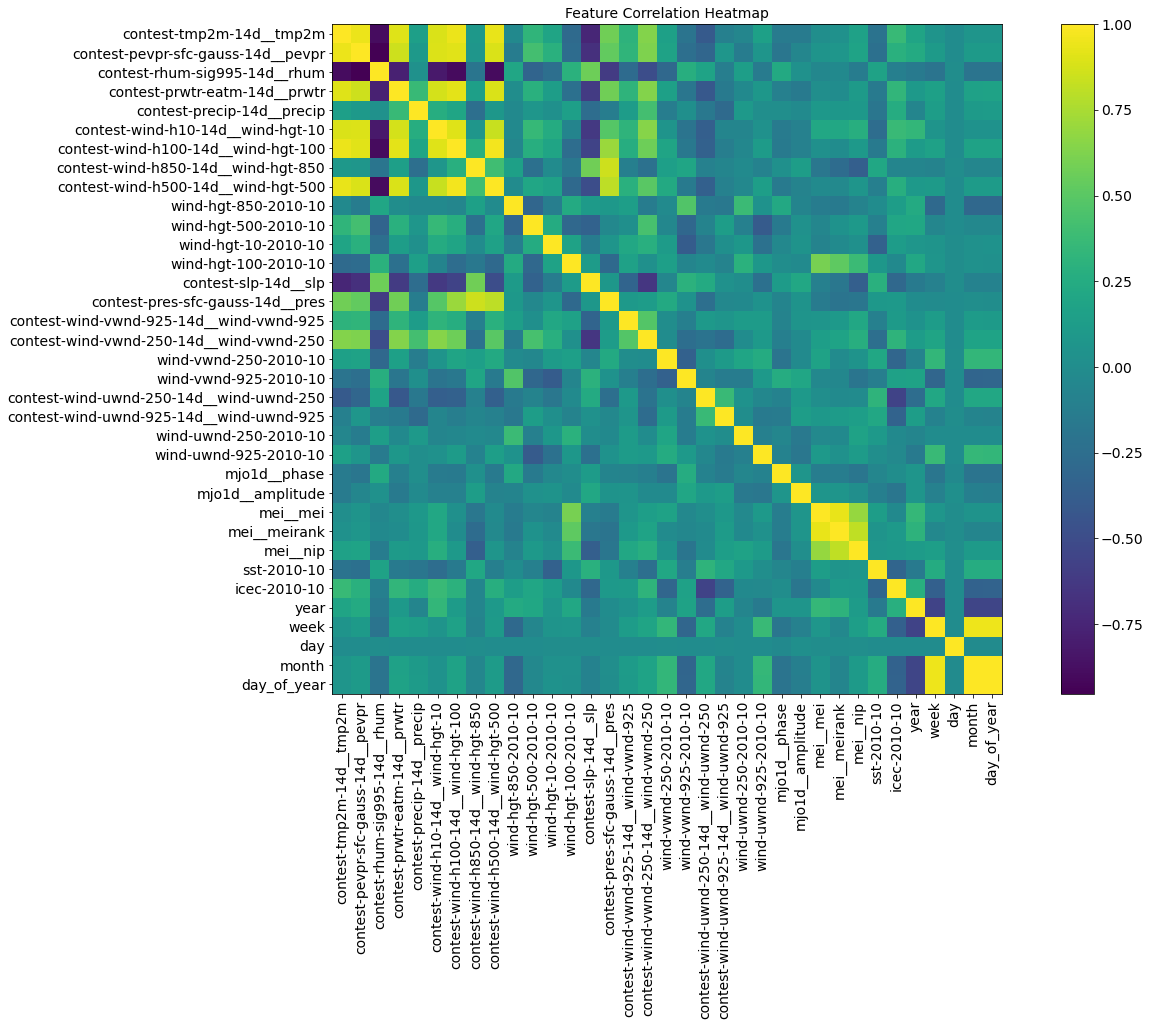

In [22]:
show_heatmap(sngl_lctn_df.drop(columns=drop_cols))

In [23]:
sngl_lctn_df.drop(columns=drop_cols).corr(numeric_only=True)[[TARGET]].sort_values(TARGET, ascending=False)

,contest-tmp2m-14d__tmp2m
contest-tmp2m-14d__tmp2m,1.000000
contest-pevpr-sfc-gauss-14d__pevpr,0.945772
contest-wind-h100-14d__wind-hgt-100,0.943449
contest-wind-h500-14d__wind-hgt-500,0.936344
contest-prwtr-eatm-14d__prwtr,0.908026
contest-wind-h10-14d__wind-hgt-10,0.886629
contest-wind-vwnd-250-14d__wind-vwnd-250,0.636706
contest-pres-sfc-gauss-14d__pres,0.576838
icec-2010-10,0.361815
wind-hgt-500-2010-10,0.323198


In [24]:
scaler = StandardScaler()

In [25]:
raw_nmrc_df = sngl_lctn_df.drop(columns=drop_cols)

In [26]:
model_cols = raw_nmrc_df.columns

In [27]:
scaler.fit(raw_nmrc_df)

StandardScaler()

In [28]:
scaled_df = pd.DataFrame(scaler.transform(raw_nmrc_df), columns=model_cols)
n_rows, n_cols = scaled_df.shape
print(f"scaled dataset -> rows: {n_rows}, cols: {n_cols}")

scaled dataset -> rows: 731, cols: 35


In [29]:
SPLIT = 0.8

In [30]:
train_rows = round(n_rows * SPLIT)
val_rows = n_rows - train_rows
print(f"split -> train: {train_rows}, validation: {val_rows}")

split -> train: 585, validation: 146


In [31]:
train_df = scaled_df.iloc[0:train_rows, :]
print(f"train dataframe: {train_df.shape}")
val_df = scaled_df.iloc[train_rows: , :]
print(f"validation dataframe: {val_df.shape}")

train dataframe: (585, 35)
validation dataframe: (146, 35)


In [32]:
x_train = train_df.drop(columns=TARGET).values
y_train = train_df[TARGET].values

In [33]:
seq_length = 15

In [34]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=seq_length,
)

In [35]:
x_val = val_df.drop(columns=TARGET).values
y_val = val_df[TARGET].values

In [36]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=seq_length,
)

In [57]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (128, 15, 34)
Target shape: (128,)


In [58]:
learning_rate = 0.001

In [72]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32, return_sequences=True)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 15, 34)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 15, 32)            8576      
                                                                 
 dense_4 (Dense)             (None, 15, 1)             33        
                                                                 
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________


In [73]:
epochs = 10

In [74]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 1.0856
Epoch 1: val_loss improved from inf to 1.03435, saving model to model_checkpoint.h5
5/5 [==============================] - 2s 124ms/step - loss: 1.0856 - val_loss: 1.0344
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 0.8524
Epoch 2: val_loss improved from 1.03435 to 0.95684, saving model to model_checkpoint.h5
5/5 [==============================] - 0s 29ms/step - loss: 0.8126 - val_loss: 0.9568
Epoch 3/10
1/5 [=====>........................] - ETA: 0s - loss: 0.8169
Epoch 3: val_loss improved from 0.95684 to 0.92415, saving model to model_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 0.6613 - val_loss: 0.9241
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.8103
Epoch 4: val_loss did not improve from 0.92415
5/5 [==============================] - 0s 24ms/step - loss: 0.5838 - val_loss: 0.9269
Epoch 5/10
1/5 [=====>........................] - ETA: 0

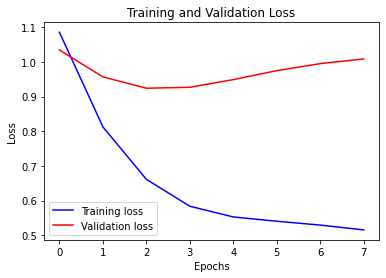

In [75]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [76]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

4/4 [==============================] - 0s 3ms/step


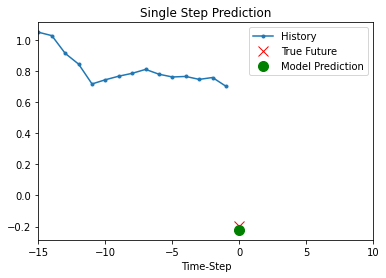

1/1 [==============================] - 0s 317ms/step


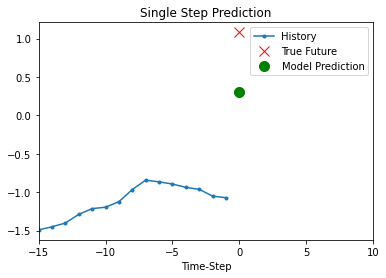

In [87]:
for x, y in dataset_val:
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0][0]],
        None,
        "Single Step Prediction",
    )

In [78]:
for x, y in dataset_val:
    print(x.shape, y.shape)

(128, 15, 34) (128,)
(4, 15, 34) (4,)


In [86]:
model.predict(x).shape

4/4 [==============================] - 0s 4ms/step


(128, 15, 1)